In [160]:
!conda info --envs
!nvidia-smi

# conda environments:
#
base                     /home/sha/anaconda3
dvaa                  *  /home/sha/anaconda3/envs/dvaa

Sat Nov 11 17:55:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     Off | 00000000:07:00.0 Off |                  Off |
| 32%   48C    P8              44W / 480W |   7880MiB / 24564MiB |      0%      Default |
|                                

In [161]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import cv2
import random

from torch import nn
from torch import Tensor
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from pytorch_model_summary import summary
import torch.nn.init as init
from timm.models.layers import trunc_normal_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


### Image Functions

In [162]:
# 이미지를 보여주기 위한 함수
def imshow(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    '''
    input: tensor [c, h, w]
    '''
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]     # unnormalize
    plt.figure(figsize=(5,5))   
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()
    plt.close()
    return img

# 이미지 패치로 나누는 함수
def split_image_into_patches(image, patch_size):
    '''
    input: tensor [c, h, w]
    '''
    _, height, width = image.shape
    patch_height, patch_width = (patch_size, patch_size)

    patch_list = []
    for i in range(0, height, patch_height):
        for j in range(0, width, patch_width):
            patch = image[:, i:i+patch_height, j:j+patch_width]
            patch_list.append(patch)

    patches = torch.stack(patch_list, dim=0) # num x c x h x w

    return patches

### Dataset

In [163]:
transform_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                    std=(0.2023, 0.1994, 0.2010)),
])

test_transform_cifar = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                    std=(0.2023, 0.1994, 0.2010)),
                                    ])


batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_cifar)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


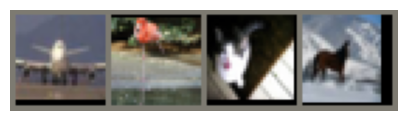

plane bird cat horse


In [164]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]

# 한 이미지(x) shape 확인하기
x = images[0]
x = x.unsqueeze(0) # add batch dim
print(x.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

### Architecture

Patch Embedding

In [165]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 8, emb_size: int = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d h w -> b d (h w)') 
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x) # [b d hw]
        x = x.permute(0,2,1) # [b hw d]
        return x

(check)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


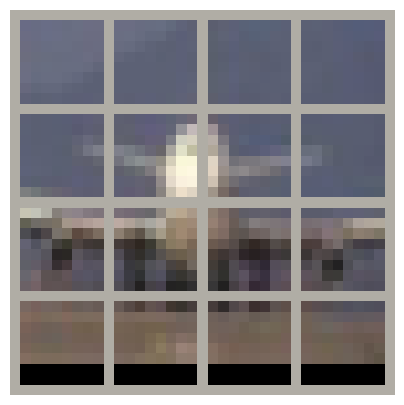

torch.Size([1, 16, 128])

In [166]:
print(x.shape) # image

x_patches = split_image_into_patches(x.squeeze(0), patch_size=8)  
imshow(torchvision.utils.make_grid(x_patches, nrow=4, ncolumn=4, padding=1, pad_value=1)) # patches

PatchEmbedding(patch_size=8)(x).shape # embedded

Positional Encoding (PE)

In [167]:
pos_num = 16 
d_model = 128 

# all positions of tokens
posses = np.arange(pos_num) # [0, 1, ..., 14, 15] (size: pos_num = 16)

# exponent of 10000
i = np.arange(d_model)//2 # [0, 0, 1, 1, ...., 63, 63] (size: d_model = 128)
two_i = 2*i # [0, 0, 2, 2, ...., 126, 126] 
exponent = two_i/d_model # [0, 0, 0.00x, 0.00x, ...., 0.9xx, 0.9x]

# fraction = positions / 10000^exponent 
denominator = np.power(10000, exponent) # [0, 0, ..., 9xxx, 9xxx] (size: d_model = 128)
fraction = posses[:, np.newaxis] / denominator # shape: pos_num x d_model = 16 x 128

# even index of PE vector -> sin(fraction) = sin(pos/10000^exponent)
# odd index of PE vector -> cos(fraction) = cos(pos/10000^exponent)
pos_emb = np.zeros((pos_num, d_model))
pos_emb[:, 0::2] = np.sin(fraction[:, 0::2]) # shape: 16 x 64
pos_emb[:, 1::2] = np.cos(fraction[:, 1::2]) # shape: 16 x 64
print(pos_emb.shape)

(16, 128)


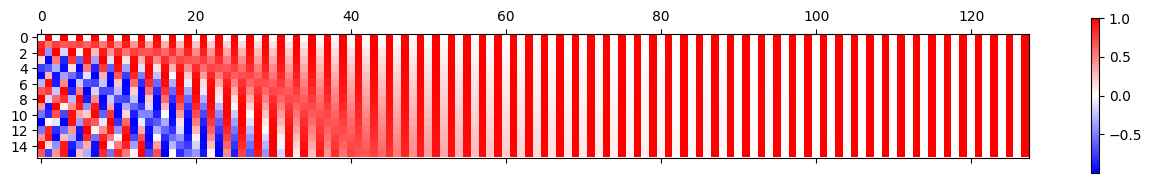

In [168]:
plt.matshow(pos_emb, cmap=plt.get_cmap('bwr'))
plt.colorbar()

Patch Embedding (w CLS token, pos_encoding)

In [169]:
def PE(pos_num, d_model, cpu=False):
    posses = np.arange(pos_num)

    i = np.arange(d_model)//2
    exponent = 2*i/d_model
    pos_emb = posses[:, np.newaxis] / np.power(10000, exponent)

    pos_emb[:, 0::2] = np.sin(pos_emb[:, 0::2])
    pos_emb[:, 1::2] = np.cos(pos_emb[:, 1::2])

    if cpu:
        pos_emb = torch.from_numpy(pos_emb)
    else:
        pos_emb = torch.from_numpy(pos_emb).to("cuda")

    return pos_emb

In [170]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, img_size: int = 32, patch_size: int = 8, emb_size: int = 128, cpu=False):
        super().__init__()
        self.patch_size = patch_size

        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d h w -> b d (h w)') 
        )
        
        # cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size)) # [1, 1, d]
        # pos encoding
        hw_plus_one = (img_size // patch_size) **2 + 1
        self.positions = PE(pos_num=hw_plus_one, d_model=emb_size, cpu=cpu) # [hw+1, d]
                
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x) # [b d hw]
        x = x.permute(0,2,1) # [b hw d]
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b) # [b, 1, d]

        x = torch.concat([cls_tokens, x], dim=1) # [b, hw+1, d]
        x += self.positions
        return x

(check)

In [171]:
PatchEmbedding(cpu=True)(x).shape

torch.Size([1, 17, 128])

Multi-Head Attention

In [172]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_size: int = 128, num_heads: int = 4, dropout: float = 0):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = emb_size
        self.head_dim = int(emb_size / num_heads)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        q = self.query(x) # [b, n, d], n=hw+1
        k = self.key(x)
        v = self.value(x)
        q = q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3) # [b, h, n, d/h]
        k = k.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,3,1) # k.t
        v = v.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)

        scaling = self.head_dim ** (1/2)
        attention = torch.softmax(q @ k / scaling, dim=-1) # [b, h, n, n]
        x = self.dropout(attention) @ v # [b, h, n, d/h]
        x = x.permute(0,2,1,3).reshape(batch_size, -1, self.embed_dim) # [b, n, d]

        return x, attention

Residual Add

In [173]:
class ResidualAdd1(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        res = x
        x, attention = self.fn(x)
        x += res
        return x, attention

In [174]:
class ResidualAdd2(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x):
        res = x
        x = self.fn(x)
        x += res
        return x

MLP

In [175]:
class MLP(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
    
    def forward(self, x):
        return self.mlp(x)

Transformer Encoder

In [176]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 128,
                 drop_p = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__()

        self.work1 = ResidualAdd1(nn.Sequential(
                                nn.LayerNorm(emb_size),
                                MultiheadAttention(emb_size, **kwargs)))
        self.work2 = ResidualAdd2(nn.Sequential(
                                nn.LayerNorm(emb_size),
                                MLP(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                                nn.Dropout(drop_p)))
        
    def forward(self, x):
        x, attention = self.work1(x)
        x = self.work2(x)
        return x, attention

(check)

In [177]:
patches_embedded = PatchEmbedding(cpu=True)(x)
TransformerEncoderBlock()(patches_embedded)[0].shape

torch.Size([1, 17, 128])

Vision Transformer (ViT)

In [178]:
class VisionTransformer(nn.Sequential):
    def __init__(self, patch_size: int = 8, emb_size: int = 128, num_layers: int = 12, num_heads: int = 4, n_classes: int = 10, cpu=False):
        super().__init__()
        self.patchembedding = PatchEmbedding(patch_size=patch_size, emb_size=emb_size, cpu=cpu)
        self.transformer = nn.ModuleList([TransformerEncoderBlock(emb_size=emb_size, num_heads=num_heads) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(nn.LayerNorm(emb_size),
                                      nn.Linear(emb_size, n_classes))

    def forward(self, x):
        x = self.patchembedding(x)
        for layer in self.transformer:
            x, attention = layer(x)
        x = self.mlp_head(x[:,0])
        return x, attention

(check)

In [179]:
model = VisionTransformer(cpu=True)
print('input:',x.shape)
print('output:',model(x)[0].shape)

input: torch.Size([1, 3, 32, 32])
output: torch.Size([1, 10])


### Training

In [180]:
patch_size = 4
emb_size = 192
num_layers = 12
n_classes = 10
num_heads = 12
num_epochs = 50
seed_value = 77
SAVE_PATH = './weight/cifar_vit_pe_conv.pth'

In [181]:
def weights_init(m):
    if isinstance(m, (nn.Linear)):
        trunc_normal_(m.weight, std=.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.LayerNorm)):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

In [182]:
# load model
net = VisionTransformer(patch_size=patch_size,
                        emb_size=emb_size,
                        num_layers=num_layers,
                        n_classes=n_classes,
                        num_heads=num_heads).to(device)
net.apply(weights_init)

# load loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-5)

tr_losses = []
val_losses = []
best_epoch = 0

# set seed
random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
torch.backends.cudnn.deterministic = True

# training
for epoch in range(num_epochs):
    train_sum_loss = 0
    val_sum_loss = 0   
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_sum_loss += loss.item()

    # record train loss
    tr_loss = train_sum_loss / len(trainloader)
    tr_losses.append(tr_loss)
    print('[%d/%d] Train CE Loss: %.4f\t'% (epoch+1, num_epochs, tr_loss))

    # validation per one epoch
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        val_sum_loss += loss.item()

    # early stopping
    val_loss = val_sum_loss / len(testloader)
    if epoch > 10:
        if val_loss < min(val_losses):
            best_epoch = epoch
            torch.save(net.state_dict(), SAVE_PATH)
            print('--------------------------------Best model save at [%d] epoch!' % (epoch+1))
    
    # record validation loss
    val_losses.append(val_loss)
    print('[%d/%d] Valiation CE Loss: %.4f\t'% (epoch+1, num_epochs, val_loss))

print('Finished Training')

[1/50] Train CE Loss: 1.8307	
[1/50] Valiation CE Loss: 1.5159	
[2/50] Train CE Loss: 1.4830	
[2/50] Valiation CE Loss: 1.3483	
[3/50] Train CE Loss: 1.3394	
[3/50] Valiation CE Loss: 1.3187	
[4/50] Train CE Loss: 1.2434	
[4/50] Valiation CE Loss: 1.1656	
[5/50] Train CE Loss: 1.1805	
[5/50] Valiation CE Loss: 1.1548	
[6/50] Train CE Loss: 1.1162	
[6/50] Valiation CE Loss: 1.1060	
[7/50] Train CE Loss: 1.0586	
[7/50] Valiation CE Loss: 1.0439	
[8/50] Train CE Loss: 1.0129	
[8/50] Valiation CE Loss: 1.0234	
[9/50] Train CE Loss: 0.9686	
[9/50] Valiation CE Loss: 0.9360	
[10/50] Train CE Loss: 0.9205	
[10/50] Valiation CE Loss: 0.9271	
[11/50] Train CE Loss: 0.8869	
[11/50] Valiation CE Loss: 0.8628	
[12/50] Train CE Loss: 0.8555	
[12/50] Valiation CE Loss: 0.8790	
[13/50] Train CE Loss: 0.8226	
--------------------------------Best model save at [13] epoch!
[13/50] Valiation CE Loss: 0.8319	
[14/50] Train CE Loss: 0.7938	
--------------------------------Best model save at [14] epoch!
[14

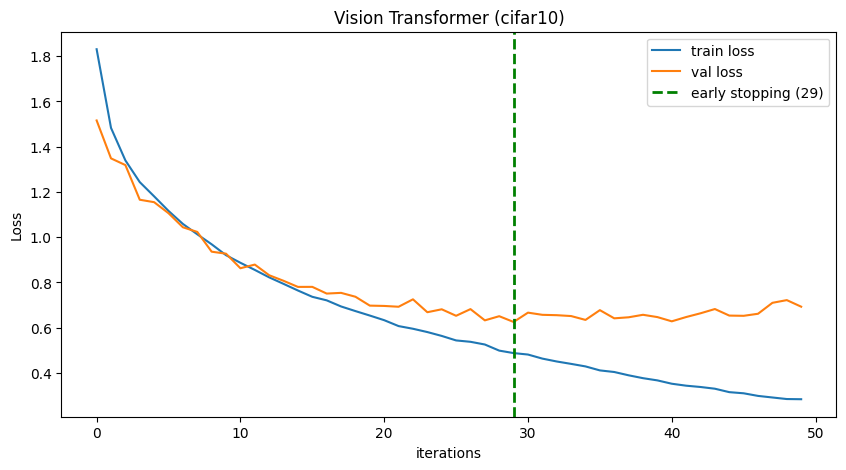

In [183]:
plt.figure(figsize=(10,5))
plt.title("Vision Transformer (cifar10)")
plt.plot(tr_losses,label="train loss")
plt.plot(val_losses,label="val loss")
plt.axvline(best_epoch, color='green', linestyle='--', linewidth=2, label=f"early stopping ({best_epoch})")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [194]:
patch_size = 4
emb_size = 192
num_layers = 12
n_classes = 10
num_heads = 12
SAVE_PATH = './weight/cifar_vit_pe_conv.pth'

net = VisionTransformer(patch_size=patch_size,
                        emb_size=emb_size,
                        num_layers=num_layers,
                        n_classes=n_classes,
                        num_heads=num_heads).to(device)

try:
    net.load_state_dict(torch.load(SAVE_PATH))
    print('load model ok!')
except:
    print('error')

load model ok!


Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


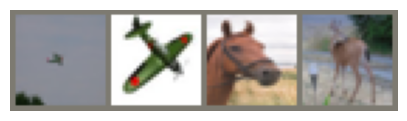

predicted:
plane plane horse deer
label:
plane plane horse deer


In [251]:
# 테스트용 이미지를 무작위로 가져오기
dataiter = iter(testloader)
images, labels = next(dataiter)

i = torch.randint(1, 101, (1,)).item()
images = images[i:i+4].to(device)
labels = labels[i:i+4].to(device)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images.cpu()))

# 예측(perdicted) 출력
outputs, _ = net(images)
_, predicted = torch.max(outputs.data, 1)
print('predicted:',sep=' ')
print(' '.join(f'{classes[predicted[j]]}' for j in range(4)))
    
# 정답(label) 출력
print('label:',sep=' ')
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

Attention Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, -0.15, 'Attentioned')

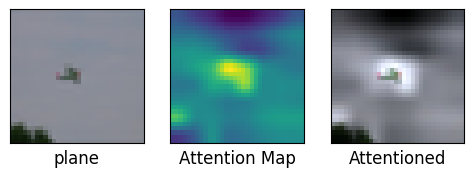

In [252]:
# 이미지 시각화 
num = 0
img = images[num].to(device)
mean=(0.4914, 0.4822, 0.4465)
std=(0.2023, 0.1994, 0.2010)
show_img = img.clone()
for i in range(3):
    show_img[i] = show_img[i] * std[i] + mean[i]  
show_img = show_img.cpu().permute(1,2,0)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 5, 1)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(show_img)
ax.text(0.5, -0.15, f'{classes[predicted[num]]}', transform=ax.transAxes, fontsize=12, ha='center')


# 어텐션 맵 시각화
output, attention = net(img.unsqueeze(0)) # [1, h, n, n]

sum_heatmap = np.zeros(shape=(32,32), dtype=np.float32) 
for i in range(num_heads): 
    attn_heatmap = attention[0, i, 0, 1:].reshape((8, 8)).detach().cpu().numpy() # cls_token row of attn map
    attn_heatmap = cv2.resize(attn_heatmap,(32,32))
    sum_heatmap += attn_heatmap
avg_heatmap = sum_heatmap / num_heads
avg_heatmap = (avg_heatmap - avg_heatmap.min()) / (avg_heatmap.max() - avg_heatmap.min())

ax = fig.add_subplot(1, 5, 2)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(avg_heatmap)
ax.text(0.5, -0.15, 'Attention Map', transform=ax.transAxes, fontsize=12, ha='center')


# 어텐션된 이미지 시각화
attn_img = show_img.clone().detach()
attn_img[:,:,0] = (attn_img[:,:,0]*avg_heatmap)*2
attn_img[:,:,1] = (attn_img[:,:,1]*avg_heatmap)*2
attn_img[:,:,2] = (attn_img[:,:,2]*avg_heatmap)*2

ax = fig.add_subplot(1, 5, 3)
ax.axes.get_xaxis().set_visible(False) 
ax.axes.get_yaxis().set_visible(False) 
ax.imshow(attn_img)
ax.text(0.5, -0.15, 'Attentioned', transform=ax.transAxes, fontsize=12, ha='center')

Evaluation

In [192]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 78.55 %
